# Boosting Modeling

In [1]:
# import the package
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report, make_scorer

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
SEED = 42

Using TensorFlow backend.


In [2]:
# load the data
df = pd.read_csv('data/clean_features.csv')
df.set_index('PetID', drop=True, inplace=True)
df.head()

,Type,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,...,10,11,12,13,14,15,16,17,18,19
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,3,1,1,1,2,2,2,1,1,...,0.009754,-0.002826,-0.018925,-0.012456,0.000584,-0.014139,-0.007550,0.018987,0.009588,0.009349
6296e909a,2,1,1,2,2,3,3,3,1,1,...,-0.010259,0.008178,0.010272,0.003087,-0.001423,-0.005038,-0.003081,0.009825,0.003104,0.006718
3422e4906,1,1,1,2,2,1,1,2,1,1,...,0.044125,-0.050633,0.041106,0.008243,0.024158,-0.030801,0.012797,-0.050066,-0.023363,-0.057766
5842f1ff5,1,4,2,2,1,1,1,2,1,1,...,-0.000498,0.044688,-0.034980,0.002213,-0.094938,0.060292,0.026551,-0.040345,-0.087958,0.000022
850a43f90,1,1,1,2,1,2,2,2,1,1,...,-0.009017,0.015145,0.099046,0.026728,0.011302,0.002314,0.000365,0.017789,0.066420,0.038391


In [3]:
# load the data
structured = pd.read_csv('data/clean_features.csv')
img_features = pd.read_csv('data/img_features.csv')
img_features = img_features.rename(columns = {'Unnamed: 0':'PetID'})

In [4]:
structured.head()

,PetID,Type,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,...,10,11,12,13,14,15,16,17,18,19
0,86e1089a3,2,3,1,1,1,2,2,2,1,...,0.009754,-0.002826,-0.018925,-0.012456,0.000584,-0.014139,-0.007550,0.018987,0.009588,0.009349
1,6296e909a,2,1,1,2,2,3,3,3,1,...,-0.010259,0.008178,0.010272,0.003087,-0.001423,-0.005038,-0.003081,0.009825,0.003104,0.006718
2,3422e4906,1,1,1,2,2,1,1,2,1,...,0.044125,-0.050633,0.041106,0.008243,0.024158,-0.030801,0.012797,-0.050066,-0.023363,-0.057766
3,5842f1ff5,1,4,2,2,1,1,1,2,1,...,-0.000498,0.044688,-0.034980,0.002213,-0.094938,0.060292,0.026551,-0.040345,-0.087958,0.000022
4,850a43f90,1,1,1,2,1,2,2,2,1,...,-0.009017,0.015145,0.099046,0.026728,0.011302,0.002314,0.000365,0.017789,0.066420,0.038391


In [5]:
img_features.head()

,PetID,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,86e1089a3,0.002000,0.167800,0.019715,0.015896,0.068162,0.002216,0.005042,0.004828,0.050760,...,0.787699,0.176626,0.575706,1.088628,0.439556,0.520460,1.547071,0.832573,0.599093,0.763348
1,6296e909a,0.002858,0.107450,0.019916,0.023482,0.174765,0.002297,0.005031,0.006338,0.083378,...,0.628259,0.686865,0.564000,0.968190,1.070276,1.545742,0.894409,0.838595,0.468238,0.916672
2,3422e4906,0.002734,0.072015,0.024455,0.018021,0.154207,0.001946,0.004211,0.001576,0.100046,...,0.579116,0.557625,1.131405,0.720513,1.496671,0.870955,1.289683,1.184462,0.465114,0.892826
3,5842f1ff5,0.002106,0.274519,0.054815,0.013727,0.089969,0.001650,0.005506,0.004295,0.118727,...,1.295853,0.326143,0.291669,1.608086,1.119176,1.470889,0.591444,0.832755,0.483021,1.134126
4,850a43f90,0.002185,0.174022,0.044818,0.016244,0.169775,0.002075,0.004421,0.004157,0.099671,...,1.092663,0.669894,0.395784,0.886075,1.219730,1.033966,1.065686,0.304054,0.438069,0.676817


In [6]:
df = structured.merge(img_features, on='PetID', how='left')
df.set_index('PetID', drop=True, inplace=True)
df.head()

,Type,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,...,246,247,248,249,250,251,252,253,254,255
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,3,1,1,1,2,2,2,1,1,...,0.787699,0.176626,0.575706,1.088628,0.439556,0.520460,1.547071,0.832573,0.599093,0.763348
6296e909a,2,1,1,2,2,3,3,3,1,1,...,0.628259,0.686865,0.564000,0.968190,1.070276,1.545742,0.894409,0.838595,0.468238,0.916672
3422e4906,1,1,1,2,2,1,1,2,1,1,...,0.579116,0.557625,1.131405,0.720513,1.496671,0.870955,1.289683,1.184462,0.465114,0.892826
5842f1ff5,1,4,2,2,1,1,1,2,1,1,...,1.295853,0.326143,0.291669,1.608086,1.119176,1.470889,0.591444,0.832755,0.483021,1.134126
850a43f90,1,1,1,2,1,2,2,2,1,1,...,1.092663,0.669894,0.395784,0.886075,1.219730,1.033966,1.065686,0.304054,0.438069,0.676817


In [7]:
df.fillna(df.mean(), inplace=True)

In [8]:
X = df.drop('AdoptionSpeed', axis=1)
y = df.AdoptionSpeed

In [9]:
# check missing values
def check_missing(df):
    missing = df.isnull().sum()
    missing_percentage = (df.isnull().sum()/len(df)*100).round(2)
    missing_val = pd.concat([missing, missing_percentage], axis=1)
    missing_val.columns = ['Missing Values', '% Missing']
    total_columns = df.shape[1]
    missing_columns = (df.isnull().sum()>0).sum()
    print('Out of {} columns, {} columns have missing values'.format(total_columns, missing_columns))
    return missing_val

check_missing(X)

Out of 322 columns, 0 columns have missing values


,Missing Values,% Missing
Type,0,0.0
Age,0,0.0
Gender,0,0.0
MaturitySize,0,0.0
FurLength,0,0.0
...,...,...
251,0,0.0
252,0,0.0
253,0,0.0
254,0,0.0


In [10]:
y.value_counts(normalize=True)

4    0.279931
2    0.269259
3    0.217368
1    0.206096
0    0.027346
Name: AdoptionSpeed, dtype: float64

In [11]:
y_bi = label_binarize(y, classes=[0, 1, 2, 3, 4])
y_bi.shape

(14993, 5)

In [12]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

## t-SNE Visualization

In [13]:
tsne = TSNE(random_state=SEED, perplexity=50, learning_rate=200)
tsne_transformed = tsne.fit_transform(X)

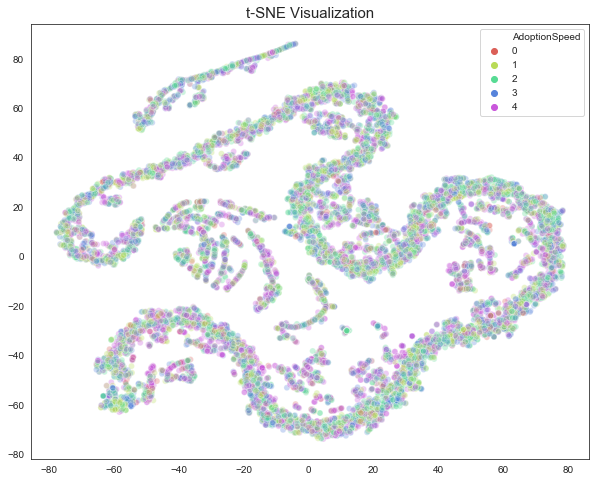

In [14]:
sns.set_style('white')
plt.figure(figsize=(10, 8))
xs = tsne_transformed[:,0]
ys = tsne_transformed[:,1]
sns.scatterplot(xs, ys, hue=y, palette=sns.color_palette('hls', 5), legend='full', alpha=0.3)
plt.title('t-SNE Visualization', fontsize=15)
plt.show()

## Modeling

### Baseline

In [15]:
scaler = StandardScaler()
smote = SMOTE(random_state=SEED)
lgbm = LGBMClassifier(objective='multiclass', random_state=SEED)
pipeline = Pipeline([('scaler', scaler), ('over', smote), ('classifier', lgbm)])
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
score = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=kfold)

In [16]:
np.mean(score)

0.38694007977963324

In [17]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('over',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=42,
                       sampling_strategy='auto')),
                ('classifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective='multiclass',
                                random_state=42, reg_alpha=0.0, reg_lambda=0.0,
                                silent=True, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [18]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))
print(cohen_kappa_score(y_test, y_pred, weights='quadratic'))
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
print(classification_report(y_test, y_pred))

0.3842351037059978
0.39379793264421475
0.38039875780614946
0.39379793264421475
0.3315770762813226
0.657711086213984
              precision    recall  f1-score   support

           0       0.38      0.04      0.07        82
           1       0.32      0.34      0.33       618
           2       0.33      0.32      0.32       807
           3       0.37      0.26      0.31       652
           4       0.50      0.64      0.56       840

    accuracy                           0.39      2999
   macro avg       0.38      0.32      0.32      2999
weighted avg       0.38      0.39      0.38      2999



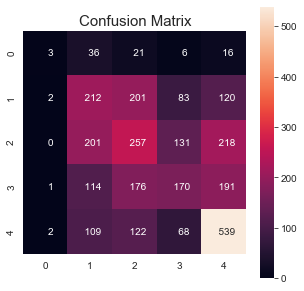

In [19]:
# visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, square=True, annot=True, fmt='5g')
plt.title('Confusion Matrix', fontsize=15)
plt.show()

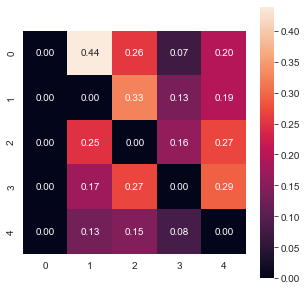

In [20]:
# normalized confusion matrix
# rows: actual classes, columns: predicted classes
row_sums = cm.sum(axis=1, keepdims=True) 
norm_conf_mx = cm / row_sums

plt.figure(figsize=(5, 5))
np.fill_diagonal(norm_conf_mx, 0) 
sns.heatmap(norm_conf_mx, square=True, annot=True, fmt='.2f') 
plt.show()

In [21]:
def feature_imp(model, X_train):
    # features and feature importances
    plt.figure(figsize = (10, 6))

    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    names = [features[i] for i in indices]

    plt.title('Feature Importance')
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), names, rotation=90)

    plt.show()

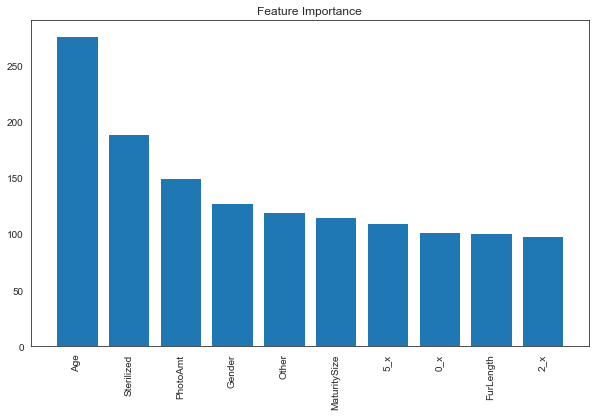

In [22]:
feature_imp(pipeline.steps[2][1], X_train)

### Tune Hyperparameter

In [23]:
def build_model(input_model, param_dist):

    # define which resampling method and which ML model to use in the pipeline
    scaler = StandardScaler()
    smote = SMOTE(random_state=SEED)
    model = input_model

    # define the pipeline
    pipeline = Pipeline([('Scaler', scaler), ('Oversampling', smote), ('Classifier', model)])

    # tune hyperparameter
    pipeline = RandomizedSearchCV(pipeline, param_distributions=param_dist, scoring='f1_weighted', \
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), \
                                  n_iter=50, verbose=0, n_jobs=-1, random_state=SEED)

    # fit the data
    pipeline.fit(X_train, y_train)
    pipeline = pipeline.best_estimator_
    
    return pipeline

In [24]:
def score(model):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    cv_f1 = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), scoring='f1_weighted', verbose=True, n_jobs=-1))
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_ck = cohen_kappa_score(y_test, y_test_pred, weights='quadratic')
    test_rocauc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    result = pd.DataFrame({'Train F1': [train_f1], 'CV F1': [cv_f1], 'Test Precision': [test_precision],\
                           'Test Recall': [test_recall], 'Test F1': [test_f1], 'Test Cohen Kappa': [test_ck],\
                           'Test ROCAUC': [test_rocauc]})
    
    return result

<b> LGBM <b/>

In [25]:
lgbm_param = {'Oversampling__k_neighbors': np.arange(3, 30),
              'Classifier__n_estimators': np.arange(50, 500),
              'Classifier__max_depth': np.arange(1, 15),
              'Classifier__num_leaves': np.arange(10, 100),
              'Classifier__min_data_in_leaf': np.arange(2, 50),
              'Classifier__learning_rate': np.arange(0.0001, 1),
              'Classifier__gamma': np.arange(0, 5),
              'Classifier__lambda_l1': np.arange(0, 500),
              'Classifier__feature_fraction': np.arange(0.5, 0.9),
              'Classifier__min_split_gain': np.arange(0.01, 0.05)
              }

In [26]:
lgbm = build_model(LGBMClassifier(objective='multiclass', random_state=SEED), lgbm_param)

In [27]:
lgbm_score = score(lgbm)
lgbm_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


,Train F1,CV F1,Test Precision,Test Recall,Test F1,Test Cohen Kappa,Test ROCAUC
0,0.439277,0.37472,0.375773,0.377459,0.362562,0.275094,0.649679


In [28]:
lgbm.get_params()

{'memory': None,
 'steps': [('Scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('Oversampling',
   SMOTE(k_neighbors=4, n_jobs=None, random_state=42, sampling_strategy='auto')),
  ('Classifier',
   LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                  feature_fraction=0.5, gamma=1, importance_type='split',
                  lambda_l1=10, learning_rate=0.0001, max_depth=7,
                  min_child_samples=20, min_child_weight=0.001,
                  min_data_in_leaf=16, min_split_gain=0.01, n_estimators=406,
                  n_jobs=-1, num_leaves=19, objective='multiclass',
                  random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                  subsample=1.0, subsample_for_bin=200000, subsample_freq=0))],
 'verbose': False,
 'Scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'Oversampling': SMOTE(k_neighbors=4, n_jobs=None, random_state=42, sampling_strategy='auto'),
 'Class

In [29]:
lgbm.steps[2][1].get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.5, gamma=1, importance_type='split',
               lambda_l1=10, learning_rate=0.0001, max_depth=7,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=16, min_split_gain=0.01, n_estimators=406,
               n_jobs=-1, num_leaves=19, objective='multiclass',
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>